[Some code](https://github.com/giannisnik/som/blob/master/som.py) for SOM in Pytorch

In [33]:
import torch
import torch.nn as nn
import numpy as np
 

class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
    def __init__(self, m, n, dim, alpha=None, sigma=None):
        super(SOM, self).__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.n_neurons = self.m * self.n
        # gain coefficient
        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)
        # correction
        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = float(sigma)

        self.weights = torch.randn(self.n_neurons, dim)
        self.locations = torch.tensor(np.array(list(self.make_grid_locations_iter(m, n))), dtype=torch.int32)
        self.pdist = nn.PairwiseDistance(p=2)

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def make_grid_locations_iter(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self.weights))],
                            key=lambda x: np.linalg.norm(vect-self.weights[x]))
            to_return.append(self.locations[min_index])

        return to_return

    def forward(self, x, learning_rate_op):
        dists = self.pdist(torch.stack([x for i in range(self.n_neurons)]), self.weights)
        _, bmu_index = torch.min(dists, 0)
        bmu_loc = self.locations[bmu_index,:]
        bmu_loc = bmu_loc.squeeze()
        
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        bmu_distance_squares = torch.sum(torch.pow(self.locations.float() - torch.stack([bmu_loc for i in range(self.n_neurons)]).float(), 2), 1)
        
        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2)))
        
        learning_rate_op = alpha_op * neighbourhood_func

        learning_rate_multiplier = torch.stack([learning_rate_op[i:i+1].repeat(self.dim) for i in range(self.n_neurons)])
        delta = torch.mul(learning_rate_multiplier, (torch.stack([x for i in range(self.n_neurons)]) - self.weights))                                         
        new_weights = torch.add(self.weights, delta)
        self.weights = new_weights

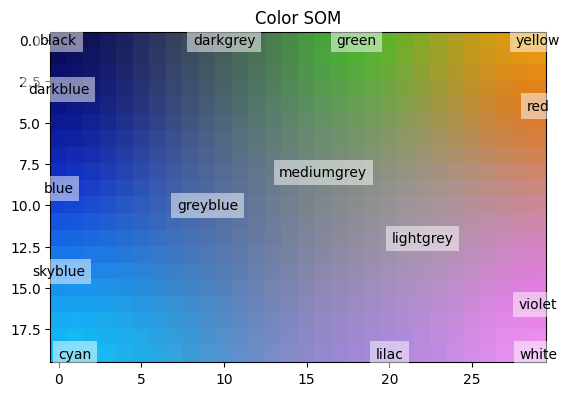

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt



#Training inputs for RGBcolors
colors = torch.tensor(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = \
    ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']

#Train a 20x30 SOM with 100 iterations
m = 20
n = 30
n_iter = 10
som = SOM(m, n, 3)
for iter_no in range(n_iter):
    #Train with each vector one by one
    for i in range(len(colors)):
        learning_rate_op = 1.0 - iter_no/(1.0*n_iter)
        som(colors[i], learning_rate_op)

#Store a centroid grid for easy retrieval later on
centroid_grid = [[] for i in range(m)]
weights = som.get_weights()
locations = som.get_locations()
for i, loc in enumerate(locations):
    centroid_grid[loc[0]].append(weights[i].numpy())

#Get output grid
image_grid = centroid_grid

#Map colours to their closest neurons
mapped = som.map_vects(colors)

#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

Let's reproduce an experiment from [Kohonen's paper](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1990-Kohonen-PIEEE.pdf). It's about random dots that become organized as a curve that evenly takes the whole space.

In [37]:
colors = torch.tensor(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])

In [41]:
n_dim = 2
n_points = 10
torch.randn(n_points, n_dim)

tensor([[ 0.7276,  0.8629],
        [-0.3685, -0.7308],
        [ 0.3868,  0.1716],
        [-0.7745, -0.1719],
        [-1.3247, -0.4044],
        [-0.2412,  0.6774],
        [-0.5215, -0.9372],
        [ 1.1064,  0.4177],
        [ 1.4770,  0.8772],
        [-0.5362, -0.4779]])

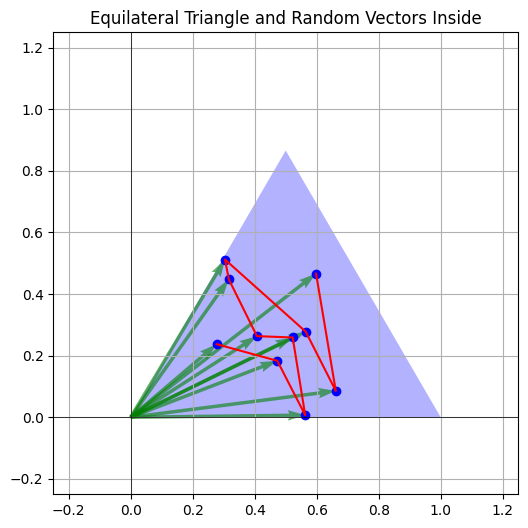

In [59]:
# Generate vertices of an equilateral triangle
triangle_side = 1.0
half_height = np.sqrt(3) / 2 * triangle_side
triangle_points = np.array([[0, 0], 
                            [triangle_side, 0], 
                            [triangle_side / 2, half_height]])

# Function to generate random barycentric coordinates
def random_barycentric_coordinates(n_points):
    barycentric_coords = torch.rand(n_points, 3)
    barycentric_coords /= barycentric_coords.sum(dim=1, keepdim=True)
    return barycentric_coords

# Generate 10 random points inside the triangle using barycentric coordinates
n_points = 10
bary_coords = random_barycentric_coordinates(n_points)

# Convert barycentric coordinates to 2D points inside the triangle
vectors_in_triangle = torch.matmul(bary_coords, torch.tensor(triangle_points).float())

# Plotting the equilateral triangle
plt.figure(figsize=(6, 6))
plt.fill(triangle_points[:, 0], triangle_points[:, 1], 'b', alpha=0.3, label="Equilateral Triangle")

# Plotting the random vectors inside the triangle
origin = np.array([0, 0])  # origin point for vectors
line_segments_x = []
line_segments_y = []
for i in range(n_points):
    vec = vectors_in_triangle[i].numpy()
    if i < n_points - 1:
        next_vec = vectors_in_triangle[i+1].numpy()
        line_segments_x.append(vec[0])
        line_segments_x.append(next_vec[0])
        line_segments_y.append(vec[1])
        line_segments_y.append(next_vec[1])
    # plt.plot(vec, next_vec, color='r')
    plt.plot(vec[0], vec[1], 'bo') 
    plt.quiver(origin[0], origin[1], vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color='g', alpha=0.6)

plt.plot(line_segments_x, line_segments_y, color='r')

# Set plot limits and labels
plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)
#plt.gca().set_aspect('equal', adjustable='box')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
#plt.legend()
plt.title('Equilateral Triangle and Random Vectors Inside')
plt.grid(True)
plt.show()


In [58]:
len(line_segments_y)

18

In [ ]:


#Train a 20x30 SOM with 100 iterations
m = 20
n = 30
n_iter = 10
som = SOM(m, n, 3)
for iter_no in range(n_iter):
    #Train with each vector one by one
    for i in range(len(data)):
        learning_rate_op = 1.0 - iter_no/(1.0*n_iter)
        som(data[i], learning_rate_op)

#Store a centroid grid for easy retrieval later on
centroid_grid = [[] for i in range(m)]
weights = som.get_weights()
locations = som.get_locations()
for i, loc in enumerate(locations):
    centroid_grid[loc[0]].append(weights[i].numpy())

#Get output grid
image_grid = centroid_grid

#Map colours to their closest neurons
mapped = som.map_vects(torch.Tensor(colors))

#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()